In [58]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [59]:
# Image size and batch size
image_size = (224, 224)
batch_size = 32
train_dir = 'data/train'
test_dir = 'data/test'

In [60]:
# Image size and batch size
image_size = (224, 224)
batch_size = 32
train_dir = 'data/train'
test_dir = 'data/test'

# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7,1.3],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 711 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


In [61]:
# Build a custom CNN model
def build_model(input_shape, num_classes):
    model = models.Sequential([
        # First convolution block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Second convolution block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Third convolution block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Fourth convolution block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [62]:
# Create model
model = build_model((*image_size, 3), train_data.num_classes)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Initial training with frozen base model...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.2986 - loss: 3.7219 - val_accuracy: 0.2982 - val_loss: 3.2700 - learning_rate: 1.0000e-04
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3005 - loss: 3.3261 - val_accuracy: 0.2807 - val_loss: 3.0128 - learning_rate: 1.0000e-04
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.3507 - loss: 3.0512 - val_accuracy: 0.3596 - val_loss: 2.7927 - learning_rate: 1.0000e-04
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.3185 - loss: 2.8117 - val_accuracy: 0.3860 - val_loss: 2.5943 - learning_rate: 1.0000e-04
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.3493 - loss: 2.6180 - val_accuracy: 0.4561 - val_loss: 2.4233 - learning_rate: 1.0000e-04
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3278 - loss: 2.4414 - val_accuracy: 0.3947 - val_loss: 2.2785 - learning_rate: 1.0000e-04
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3368 - loss:

In [63]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
print("Training the custom CNN model...")
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

# Evaluation
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

3/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x2a52bfb00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


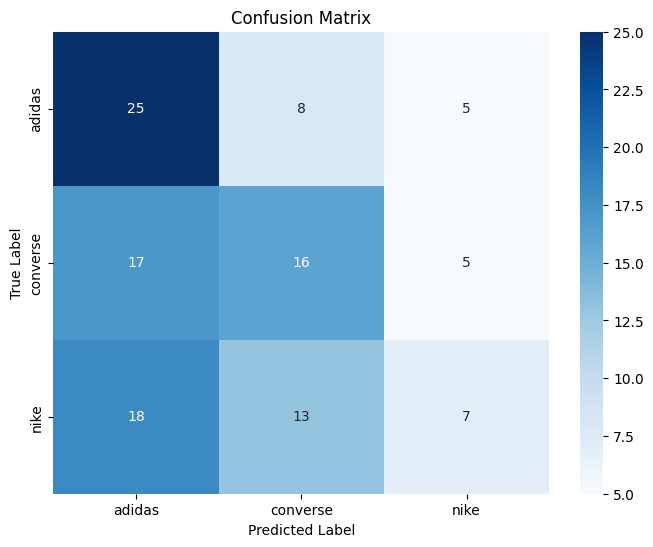

In [64]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_data.class_indices.keys())

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [52]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      adidas       0.00      0.00      0.00        38
    converse       0.32      0.95      0.48        38
        nike       0.00      0.00      0.00        38

    accuracy                           0.32       114
   macro avg       0.11      0.32      0.16       114
weighted avg       0.11      0.32      0.16       114



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  